# 0. Preparations

In [1]:
# standard dependencies
import qutip as qt
import numpy as np

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

# for creating animations with matplotlib
import matplotlib.animation as animation

/Users/RichardLi/anaconda3/envs/qutip-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# all values in this cell apply to entire notebook unless otherwise specified 

# basic variables
N = 400
a = qt.destroy(N)
x = 1/2*(a+a.dag())
p = -1j/2*(a-a.dag())

# font styles for plots
csfont_title = {"fontname":"Times New Roman", "size": 25}
csfont_axestitles = {"fontname":"Times New Roman", "size": 20}
csfont_axesticks= {"fontname":"Times New Roman", "size": 18}
csfont_colorbar = {"fontname":"Times New Roman", "size": 18}


# use latex and times new roman for plots
# plt.rcParams.update({
#    "text.usetex": True,
#     "text.latex.preamble": [r"\usepackage{amsmath}"],
# "mathtext.fontset": "cm",
#    "font.serif": "Times New Roman",
# })

In [3]:
# set figure quality
# may need to run this cell again if figures aren't good quality
mpl.rcParams.update({
    "figure.dpi": 1000
})

In [4]:
mpl.rcParams.update({
    "figure.dpi": 1000
})

# Big-Small-Small cat state preparation

# $\hat{U}_1(\alpha) = e^{-i\alpha \left(2\hat{p}\right) \otimes \hat{\sigma}_x}$

# $\hat{U}_2(\alpha)= e^{-i\left(\frac{\hat{x}}{\alpha}\right) \otimes \left(\frac{\left(\frac{-\pi}{2}\right)}{2}\right) \hat{\sigma}_y} = e^{+i\left(\frac{\pi}{8\alpha}\right) \left( 2\hat{x} \right) \otimes \hat{\sigma}_y}$
# $\hat{U}_3 = e^{-i\epsilon(2\hat{p}) \otimes \hat{\sigma}_x} = e^{-i\left(\frac{\pi}{8 \alpha}\right)\left(2\hat{p}\right) \otimes \hat{\sigma}_x}$
- $\epsilon \equiv \frac{\pi}{8\alpha}$

In [5]:
def U1_BSS(alpha):
    return qt.tensor(-1j*alpha*(2*p), qt.sigmax()).expm()
    
def U2_BSS(alpha):
    return qt.tensor(1j*(np.pi/(8*alpha))*(2*x), qt.sigmay()).expm()

def U3_BSS(alpha):
    return qt.tensor(-1j*(np.pi/(8*alpha))*(2*p), qt.sigmax()).expm()

# 6.  Performance of preparing $|CS(\alpha)\rangle$ for $\alpha \in [0, 8]$

In [6]:
def bigsmallsmall_prep(alpha):
    
    # define initial state
    psi_0 = qt.tensor(qt.coherent(N, 0), qt.basis(2,0))
    
    # use protocol to get final state
    psi_3 = U3_BSS(alpha) * U2_BSS(alpha) * U1_BSS(alpha) * psi_0
    
    return psi_3

In [7]:
def bigsmallsmall_prep_fidelity(alpha):
    
    target = qt.tensor(qt.coherent(N, alpha) + qt.coherent(N, -alpha), qt.basis(2,0)).unit()
    psi_3 = bigsmallsmall_prep(alpha)
    
    return qt.fidelity(target, psi_3)

In [8]:
alpha_array = np.arange(start=1, stop=10, step=0.2)
fidelity_array = []

for alpha in alpha_array:
    
    fidelity = bigsmallsmall_prep_fidelity(alpha)
    fidelity_array.append(fidelity)

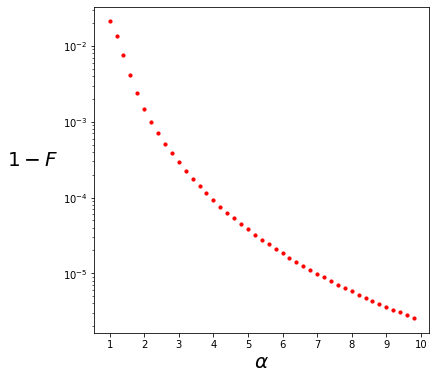

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(alpha_array, 1 - np.array(fidelity_array),
           s=10, c="red")
ax.set_yscale("log")
ax.set_xlabel(r"$\alpha$", rotation=0, **csfont_axestitles)
ax.set_xticks(np.arange(start=1, stop=11, step=1)) 
ax.set_ylabel(r"$1 - F$", 
              rotation=0, 
              **csfont_axestitles,
              labelpad=30)

plt.show()

# Big-Small-Small cat state amplification

# 9. Performance of amplifications $|CS(\alpha)\rangle \rightarrow |CS(\alpha+\Delta) \rangle$  where $\alpha \in [1, 6]$ and  $\Delta = \alpha$

In [10]:
# define infidelity function for Big-Small-Small
def BSS_amp_infidelity(alpha, Delta):
    
        # define target state
        target_state = qt.tensor(qt.coherent(N, alpha+Delta) + qt.coherent(N, -(alpha+Delta)), qt.basis(2,0)).unit()
     
        # prepare hybrid system
        qubit_init = qt.basis(2, 0)
        oscillator_init = qt.coherent(N, alpha) + qt.coherent(N, -alpha)
        psi_0 = qt.tensor(oscillator_init, qubit_init).unit()

        # first step
        psi_1 = U3_BSS(alpha).dag() * psi_0

        # second step
        psi_2 = U2_BSS(alpha).dag() * psi_1

        # third step
        psi_3 = U1_BSS(Delta) * psi_2

        # fourth step
        psi_4 = U2_BSS(alpha+Delta) * psi_3

        # fifth step
        psi_5 = U3_BSS(alpha+Delta) * psi_4
        
        # get infidelity
        return 1-qt.fidelity(psi_5, target_state)

In [11]:
# create meshgrid to evaluate fidelity F(alpha, Delta)
alpha_array = np.linspace(start=1, stop=5, num=50)

In [12]:
# evaluate all infidelities
BSS_amp_infidelities_array= []

for alpha in alpha_array:
    
    infidelity = BSS_amp_infidelity(alpha, alpha)
    BSS_amp_infidelities_array.append(infidelity)

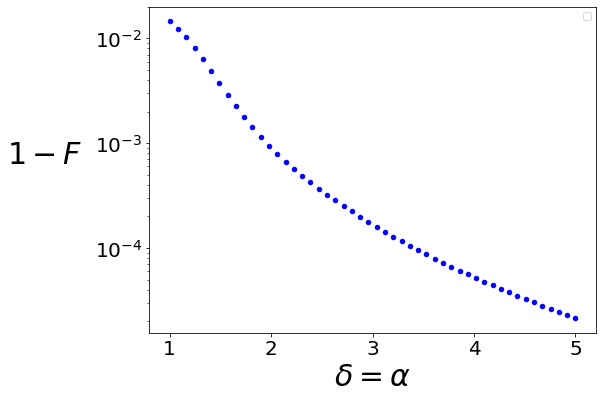

In [13]:
# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Scatter plots
ax.scatter(alpha_array, BSS_amp_infidelities_array,
           s=20, c="blue")

# Legend font properties
font = mpl.font_manager.FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

# Legend
legend = ax.legend(prop=font)
legend.set_title(None)  # Remove legend title
plt.setp(legend.get_texts(), fontsize=30)

# Set y-axis to log scale
ax.set_yscale("log")

# Set x-axis and y-axis labels
csfont_axestitles = {'fontsize': 30, 'fontweight': 'bold'}
ax.set_xlabel(r"$\delta=\alpha$", rotation=0, **csfont_axestitles)
ax.set_ylabel(r"$1 - F$", rotation=0, **csfont_axestitles, labelpad=50)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=20)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=20)  # Adjust y-axis tick label size

plt.show()

# 10.  $\widehat{BB1}_{y,\theta'}(\theta)$ unconditional

In [14]:
phi_1 = (0.5 - 0.539893088) * np.pi
phi_2 = (0.5 - 1.61967926) * np.pi

# 11.  $\widehat{BB1}_{y,\theta'}(\theta)$ cat state preparation

In [15]:
theta_nom = np.pi/2 

def BB1(alpha):
    
    theta = -np.pi/(2*alpha)
    
    # prepare rotations
    R_3 = qt.tensor(x, -1j*(2*theta)/2 *(np.cos(phi_1)*qt.sigmax() + np.sin(phi_1)*qt.sigmay())).expm()
    R_2 = qt.tensor(x, -1j*(4*theta)/2 *(np.cos(phi_2)*qt.sigmax() + np.sin(phi_2)*qt.sigmay())).expm()
    R_1 = qt.tensor(x, -1j*(2*theta)/2 *(np.cos(phi_1)*qt.sigmax() + np.sin(phi_1)*qt.sigmay())).expm()
    R_0 = qt.tensor(x, (-1j*(theta)/2 *(qt.sigmay()))).expm()
    
    return R_3*R_2*R_1*R_0

# Test over different $\alpha$ and compare to Big-Small-Small

In [16]:
def bb1_prep(alpha):
    
    # define initial state
    psi_0 = qt.tensor(qt.coherent(N, 0), qt.basis(2,0))
    
    # use protocol to get final state
    psi_2 = BB1(alpha) *  U1_BSS(alpha) * psi_0
    
    return psi_2

def bb1_prep_fidelity(alpha):
    
    target = qt.tensor(qt.coherent(N, alpha) + qt.coherent(N, -alpha), qt.basis(2,0)).unit()
    psi_2 = bb1_prep(alpha)
    
    return qt.fidelity(target, psi_2)

In [17]:
alpha_array = np.arange(start=1, stop=10, step=0.2)
bb1_fidelity_array = []
bss_fidelity_array = []

for alpha in alpha_array:
    bb1_fidelity = bb1_prep_fidelity(alpha)
    bb1_fidelity_array.append(bb1_fidelity)

for alpha in alpha_array:
    bss_fidelity = bigsmallsmall_prep_fidelity(alpha)
    bss_fidelity_array.append(bss_fidelity)

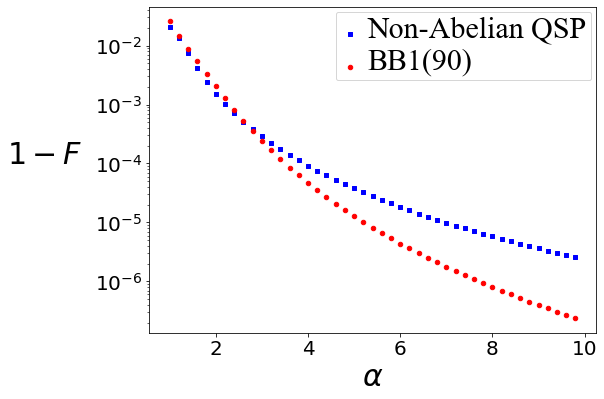

In [18]:
# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Scatter plots
ax.scatter(alpha_array, 1 - np.array(bss_fidelity_array),
           s=20, c="blue", label="Non-Abelian QSP", marker="s")
ax.scatter(alpha_array, 1 - np.array(bb1_fidelity_array),
           s=20, c="red", label="BB1(90)")

# Legend font properties
font = mpl.font_manager.FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

# Legend
legend = ax.legend(prop=font)
legend.set_title(None)  # Remove legend title
plt.setp(legend.get_texts(), fontsize=30)

# Set y-axis to log scale
ax.set_yscale("log")

# Set x-axis and y-axis labels
csfont_axestitles = {'fontsize': 30, 'fontweight': 'bold'}
ax.set_xlabel(r"$\alpha$", rotation=0, **csfont_axestitles)
ax.set_ylabel(r"$1 - F$", rotation=0, **csfont_axestitles, labelpad=50)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=20)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=20)  # Adjust y-axis tick label size

plt.show()

# 12.  $\widehat{BB1}_{y,\theta'}(\theta)$ cat state amplification

In [19]:
# define infidelity function for BB1
def BB1_amp_infidelity(alpha, Delta):
    
        # define target state
        target_state = qt.tensor(qt.coherent(N, alpha+Delta) + qt.coherent(N, -(alpha+Delta)), qt.basis(2,0)).unit()
     
        # prepare hybrid state
        qubit_init = qt.basis(2, 0)
        oscillator_init = qt.coherent(N, alpha) + qt.coherent(N, -alpha)
        psi_0 = qt.tensor(oscillator_init, qubit_init).unit()

        # first step
        psi_1 = BB1(alpha).dag() * psi_0

        # third step
        psi_2 = U1_BSS(Delta) * psi_1

        # third step
        psi_3 = BB1(alpha+Delta) * psi_2
        
        # get infidelity
        return 1-qt.fidelity(psi_3, target_state)
    
vectorized_bb1_amp_infidelity = np.vectorize(BB1_amp_infidelity)

In [20]:
# create meshgrid to evaluate fidelity F(alpha, Delta)
alpha_array = np.linspace(start=1, stop=5, num=50)

In [21]:
# evaluate all infidelities
BB1_amp_infidelities_array= []

for alpha in alpha_array:
    
    infidelity = BB1_amp_infidelity(alpha, alpha)
    BB1_amp_infidelities_array.append(infidelity)

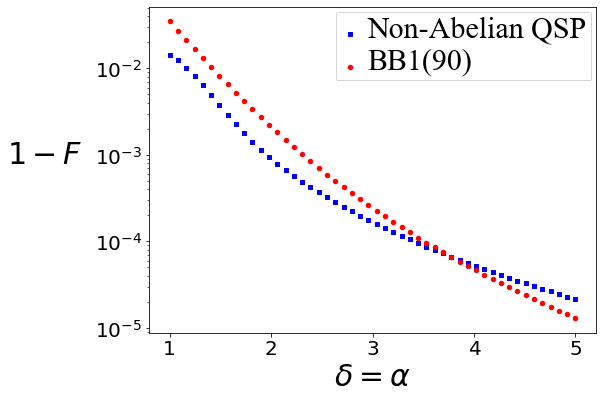

In [22]:
# plot these results side-by-side with those from BSS

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Scatter plots
ax.scatter(alpha_array, BSS_amp_infidelities_array,
           s=20, c="blue", label="Non-Abelian QSP", marker="s")
ax.scatter(alpha_array, BB1_amp_infidelities_array,
           s=20, c="red", label="BB1(90)")

# Legend font properties
font = mpl.font_manager.FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

# Legend
legend = ax.legend(prop=font)
legend.set_title(None)  # Remove legend title
plt.setp(legend.get_texts(), fontsize=30)

# Set y-axis to log scale
ax.set_yscale("log")

# Set x-axis and y-axis labels
csfont_axestitles = {'fontsize': 30, 'fontweight': 'bold'}
ax.set_xlabel(r"$\delta=\alpha$", rotation=0, **csfont_axestitles)
ax.set_ylabel(r"$1 - F$", rotation=0, **csfont_axestitles, labelpad=50)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=20)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=20)  # Adjust y-axis tick label size

plt.show()